# Задание 3 «Оптимизация показов landing pages»
Landing page – специальная страница, напрямую не взаимосвязанная с официальным сайтом my.beeline.kz, на которой можно зарегистрироваться в ЛК абонента.
Существует N таких страниц. Для каждой страницы собраны данные о том, сколько абонентов ее посетило и сколько затем зарегистрировалось («сконвертилось» в регистрации). Также для каждого абонента собраны данные о браузере и его версии, операционной системе и стране.
Необходимо предложить алгоритм увеличения конверсии абонентов в регистрации в ЛК путем показа абоненту более предпочтительной landing страницы.
В файле «Landing Page Data» находится статистика по 3 лэндингам. Если в поле user_id отсутствует информация, это означает, что абонент в процессе показа лэндинга не зарегистрировался в ЛК.

In [1]:
import pandas as pd
%matplotlib inline
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.combine import SMOTEENN 
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
pd.options.display.max_columns = 400
pd.options.display.max_rows = 100
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb

In [2]:
df = pd.read_csv('Landing Page Data.csv')

In [3]:
df['user_id'] = df['user_id'].fillna('No_data')

In [4]:
print( 'Общая конверсия =',100 * (df.shape[0]-df[df['user_id']=='No_data'].shape[0])/df.shape[0],'%')

Общая конверсия = 14.17302469934049 %


# Конверсии в разрезе Landing_page

In [5]:
landing_page_list = list(df.landing_page.unique())
for i in range(len(landing_page_list)):
    cond = (df['landing_page']==landing_page_list[i])
    print(landing_page_list[i],'конверсия =',100 * (df[cond].shape[0]-df[cond][df['user_id']=='No_data'].shape[0])/df[cond].shape[0],'%')

lpbeeline1 конверсия = 14.35483870967742 %
beetvsupport конверсия = 17.224080267558527 %
info-page-b конверсия = 0.0 %


C:\Users\mkhamzanov\AppData\Local\Continuum\miniconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


# Вывод:
>Страница **beetvsupport** имеет наиболее высокую конверсию среди остальных страниц. Почти на 3% выше чем в в среднем по всем страницам. Можем сделать вывод, что она эффективнее. 

>Страница **info-page-b** неэффективна и имеет нулевую конверсию.

Но давайте посмотрим влияние остальных признаков. Сформируем целевое событие, если пользователь зашел на страницу, то будем считать это успешным событием и пометим **1**, иначе пометим **0**. Поле **TARGET**

# Target

In [6]:
df.ix[df.user_id =='No_data', 'Target'] = 0
df.ix[df.user_id !='No_data', 'Target'] = 1
#df.head()

C:\Users\mkhamzanov\AppData\Local\Continuum\miniconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.


In [7]:
df = df.drop('user_id', axis=1)

In [8]:
df = df.fillna('No_data')

# Change time format

In [9]:
df['Time'] =  pd.to_datetime(df['show_date_time'], format='%m/%d/%Y %H:%M')

In [10]:
df['Hour'] = df.Time.dt.hour
df['Hour'] = df['Hour'].astype(str)

In [11]:
df = df.drop(['show_date_time','Time'],axis=1)

# Закодируем

In [12]:
df = pd.get_dummies(df)

In [13]:
print(df.shape[0], ' - size of observation')
print(df.shape[1], ' - size of prediction')

15466  - size of observation
438  - size of prediction


# Описание

In [14]:
df.describe().T.head()

,count,mean,std,min,25%,50%,75%,max
Target,15466.0,0.141730,0.348785,0.0,0.0,0.0,0.0,1.0
landing_page_beetvsupport,15466.0,0.154662,0.361594,0.0,0.0,0.0,0.0,1.0
landing_page_info-page-b,15466.0,0.043579,0.204164,0.0,0.0,0.0,0.0,1.0
landing_page_lpbeeline1,15466.0,0.801759,0.398688,0.0,1.0,1.0,1.0,1.0
browser_version_1/4/2003,15466.0,0.000194,0.013927,0.0,0.0,0.0,0.0,1.0


# Описание по целевой переменной

In [15]:
churn_summary = df.groupby('Target')
q = churn_summary.mean().T
q.head()

Target,0.0,1.0
landing_page_beetvsupport,0.149164,0.187956
landing_page_info-page-b,0.050776,0.000000
landing_page_lpbeeline1,0.800060,0.812044
browser_version_1/4/2003,0.000226,0.000000
browser_version_1/5/2001,0.000075,0.000000


# Корреляции

In [16]:
CorrKoef = df.corr()
CorField985 = []
print ('----- 2.1 Correlations')
print ('cor |field| > .9')
for i in CorrKoef:
    for j in CorrKoef.index[(CorrKoef[i] > 0.85) | (CorrKoef[i] < -0.85)]:
        if i != j and j not in CorField985 and i not in CorField985:
            CorField985.append(j)
            print ("%s----->%s: r^2=%f" % (i,j, CorrKoef[i][CorrKoef.index==j].values[0]))

----- 2.1 Correlations
cor |field| > .9
landing_page_beetvsupport----->landing_page_lpbeeline1: r^2=-0.860203
browser_version_2.0----->browser_BingBot: r^2=0.990306
browser_version_2.32.1----->browser_SeaMonkey: r^2=1.000000
browser_version_27.0.1453.116----->country_BY: r^2=0.865997
browser_version_35.0----->browser_Firefox: r^2=0.874732


# Разница между средними значениями в разрезе целевой переменной отсортированная по разнице

In [17]:
churn_summary = df.groupby('Target')
q = churn_summary.mean().T
q = pd.DataFrame(q)
q['diff'] = 100*(q[q.columns[1]] - q[q.columns[0]]) / q[q.columns[0]]
q.sort_values('diff', ascending=1).head(30)

Target,0.0,1.0,diff
browser_version_39.0.2100.0,0.000075,0.0,-100.0
browser_version_32.0.1700.102,0.000452,0.0,-100.0
browser_version_6.0.2,0.000151,0.0,-100.0
browser_version_32.0.1700.20,0.000075,0.0,-100.0
browser_version_32.0.1700.68,0.000151,0.0,-100.0
browser_version_32.0.1700.99,0.000075,0.0,-100.0
browser_version_6.0.1,0.000151,0.0,-100.0
browser_version_6.0,0.002637,0.0,-100.0
browser_version_33.0.1750.117,0.000075,0.0,-100.0
browser_version_33.0.1750.12,0.000075,0.0,-100.0


In [18]:
X = df.drop('Target', axis=1)
#X = df.drop(['Target','duration'], axis=1)
y = df.Target

In [28]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.05, random_state = 123,stratify=y)
N_train, _ = X_train.shape 
N_test,  _ = X_test.shape 
print(N_train, N_test)

14692 774


# Строим дерево решений на всей выборке, дабы отоборать самые значимые предикторы и посмотреть конверсию в разрезе данных предикторов

# Dtree

In [29]:
from sklearn.tree import DecisionTreeClassifier
dtree=DecisionTreeClassifier(max_depth=8)
dtree.fit(X_train,y_train)
roc = roc_auc_score(y_test,dtree.predict_proba(X_test)[:,1] )
print('Roc_Auc -', roc)

Roc_Auc - 0.697213855422


>Мы построили дерево решений и убедились в том, что оптимального способа поднять конверсию нет. Мы обучились и решили выявить признаки наиболее влияющие на целевое событие, в данном случае на конверсию.

In [36]:
confusion_matrix(y_test, dtree.predict(X_test))

array([[663,   1],
       [110,   0]], dtype=int64)

>Наша модель не видит целевое событие, но тем не менее выявим наиболее важные признаки.

# Визуализация дерева решений

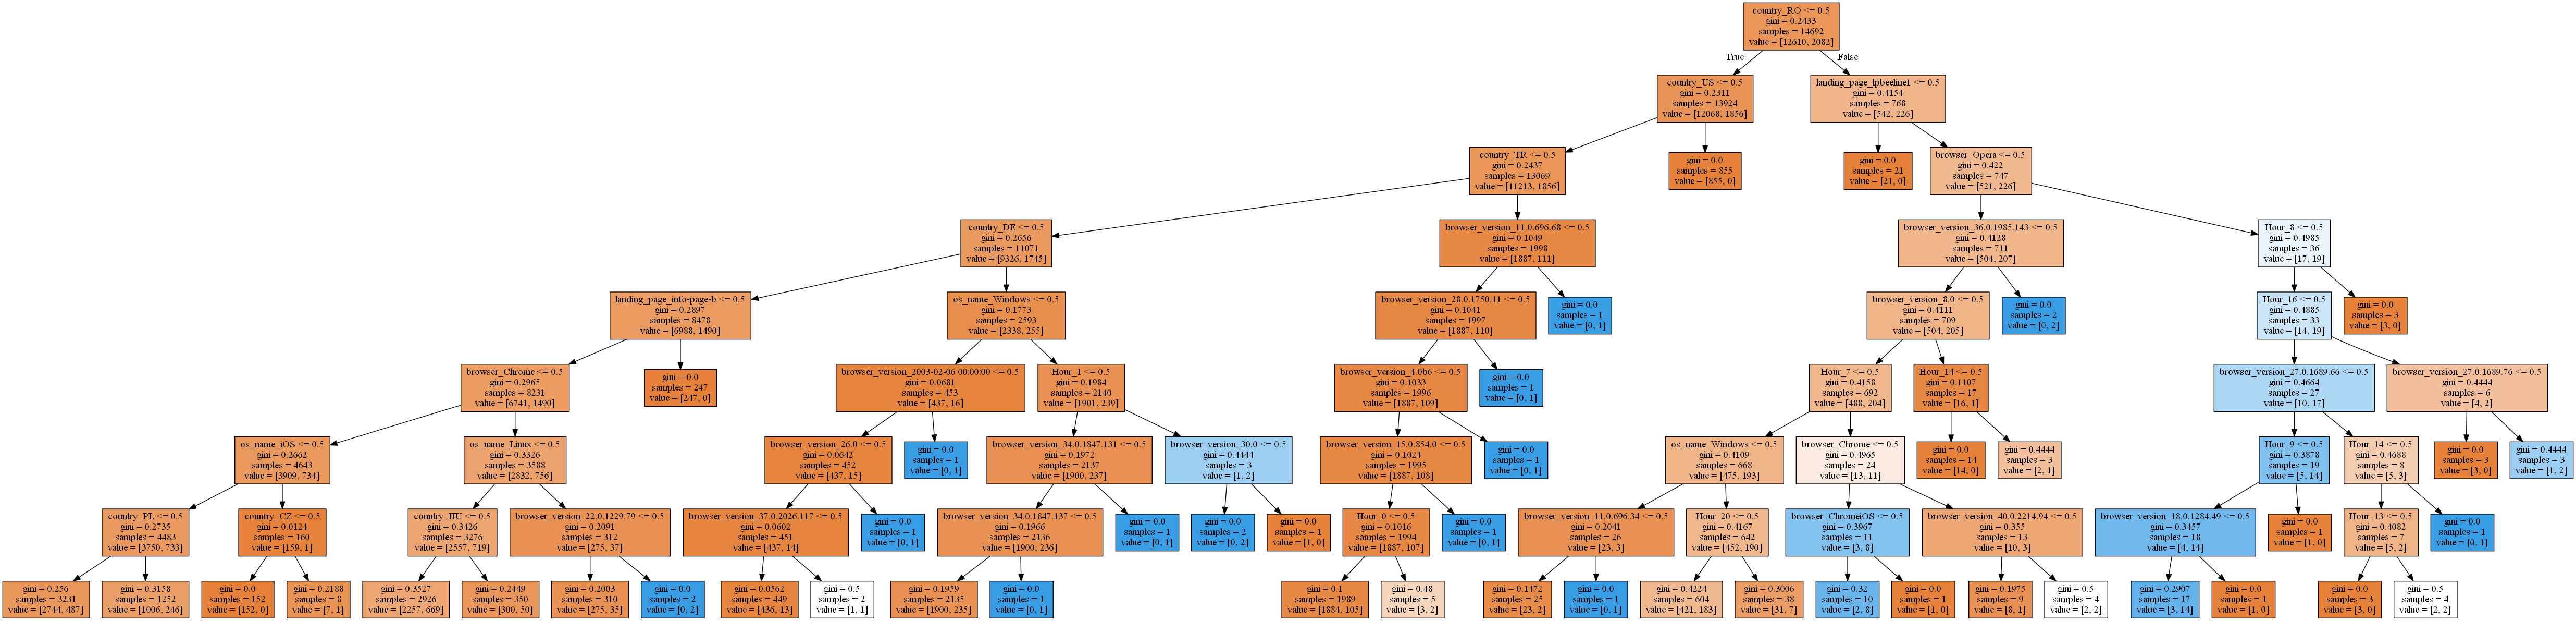

# Самые важные показатели влияющие на конверсию

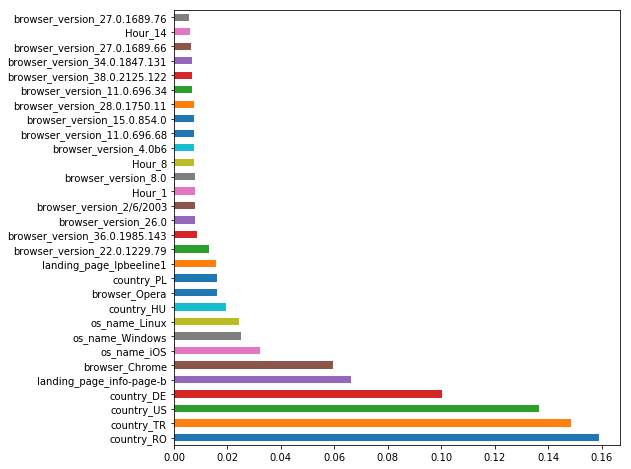

In [37]:
plt.figure(figsize=(8,8))
pd.Series(dtree.feature_importances_, index=X_train.columns).sort_values(ascending=False).head(30).plot(kind='barh')

In [40]:
#plt.figure(figsize=(8,8))
tmp_df = pd.Series(dtree.feature_importances_, index=X_train.columns).sort_values(ascending=False).head(10).to_frame()
tmp_df.T.columns

Index(['country_RO', 'country_TR', 'country_US', 'country_DE',
       'landing_page_info-page-b', 'browser_Chrome', 'os_name_iOS',
       'os_name_Windows', 'os_name_Linux', 'country_HU'],
      dtype='object')

In [41]:
pred_df = pd.DataFrame(columns=['VarName','ConversionA','SizeOfSampleA','ConversionB','SizeOfSampleB'])
a = tmp_df.T.columns
for i in range(len(a)):
    col_name = a[i]
    a1 = (a[i])
    a2 = (100*df[df[col_name]==0].Target.sum()/df[df[col_name]==0].shape[0])
    a3 = (100*df[df[col_name]==0].shape[0]/df.shape[0])
    a4 = 100*df[df[col_name]==1].Target.sum()/df[df[col_name]==1].shape[0]
    a5 = 100*df[df[col_name]==1].shape[0]/df.shape[0]
    a6 = pd.DataFrame([[a1,a2,a3,a4,a5]],columns=['VarName','ConversionA','SizeOfSampleA','ConversionB','SizeOfSampleB'])
    pred_df = pred_df.append(a6)

# Конверсия в разрезе 

In [42]:
pred_df

,VarName,ConversionA,SizeOfSampleA,ConversionB,SizeOfSampleB
0,country_RO,13.344249,94.775637,29.207921,5.224363
0,country_TR,15.534926,86.363636,5.547653,13.636364
0,country_US,15.045645,94.200181,0.000000,5.799819
0,country_DE,15.111530,82.322514,9.802487,17.677486
0,landing_page_info-page-b,14.818821,95.642054,0.000000,4.357946
0,browser_Chrome,12.657631,54.862279,16.014898,45.137721
0,os_name_iOS,14.465866,97.930945,0.312500,2.069055
0,os_name_Windows,6.685499,13.733351,15.365013,86.266649
0,os_name_Linux,14.682958,92.079400,8.244898,7.920600
0,country_HU,14.187206,94.704513,13.919414,5.295487


# Выводы и советы

**contry_RO**
>Показ рекламы в данной стране наиболее эффективен, т.к. более чем в два раза превышает конверсию.

>Увеличить показ в данной стране

**country_TR**
>Показ рекламы в данной стране неэффективен, конверсия в три раза ниже.

>Уменьшить показ в данной стране

**country_US**
>В Америке реклама не работает

>Убрать показ в данной стране

**country_DE**
>Показ рекламы в данной стране неэффективен
 
>Уменьшить показ в данной стране

**landing_page_info-page-b**
>Данная страница не эффективна, конверсия нулевая

>Убрать показ либо сменить страницу

**browser_Chrome**
>Пользователи Хрома на чуть лучше откликаются на страницы

**os_name_iOS**
>Пользователи os_name_iOS не откликаются на страницы

**os_name_Windows**
>Люди не пользующиеся Windows меньше откликаются на страницы

**os_name_Linux**
>Пользователи os_name_Linux плохо откликаются на страницы